### Starbucks Capstone Challenge
# Model Training

This notebook aims to train the models proposed to classify offers as appropriate or not.

## Define functions to train the classifiers

### Import the necessary libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim

from models import LinearNN, RecurrentNN

### Load the datasets

In [2]:
!unzip -o dataloaders.zip
train_dataloader, valid_dataloader, test_dataloader = \
    torch.load('dataloaders.pt')

Archive:  dataloaders.zip
  inflating: dataloaders.pt          


### Define validation and training loops

In [3]:
def validate(model, dataloader=valid_dataloader, verbose=False):
    with torch.no_grad():
        model.eval()
        POS, NEG = 0, 0
        TP, TN, FP, FN = 0, 0, 0, 0
        valid_loss = 0
        for features, targets in dataloader:
            targets = targets.view(-1)
            positive = targets == 1
            negative = ~positive

            prediction = model(features)
            prediction = prediction.view(-1,1)
            targets = targets.view(-1,1).to(dtype=torch.float)
            valid_loss += criterion(prediction, targets)

            prediction = torch.sigmoid(prediction)
            prediction = prediction.round()

            ## Compare prediction with target POSITIVE
            POS += positive.sum()
            # Target TRUE, Prediction TRUE --> True Positive
            TP += targets[positive].eq(prediction[positive]).sum()

            ## Compare prediction with target NEGATIVE
            NEG += negative.sum()
            # Target FALSE, Prediction FALSE --> True Negative
            TN += targets[negative].eq(prediction[negative]).sum()

        FN += POS - TP # Target TRUE, Prediction FALSE --> False Negative
        FP += NEG - TN # Target FALSE, Prediction TRUE --> False Positive

        # normalize the loss
        valid_loss /= len(dataloader)

        if verbose:
            print(f'\tValidation ... loss: {valid_loss:7.4f}')
            print(f'\t\tTP: {TP:4d}\tFP: {FP:4d}\tOP: {TP+FP:4d}')
            print(f'\t\tFN: {FN:4d}\tTN: {TN:4d}\tON: {TN+FN:4d}')
            print(f'\t\tCP: {POS:4d}\tCN: {NEG:4d}')
            print('\tAccuracy: {:5.2f}%\tPrecision: {:5.2f}\tRecall: {:5.2f}'
                  .format((TP+TN)/float(POS+NEG)*100,
                          TP/float(TP+FP), TP/float(TP+FN)))

        model.train()
        return valid_loss

In [4]:
def train(model, model_name='classifier',
          dataloader=train_dataloader, epochs=5000):
    train_loss = []
    valid_loss = []
    min_valid_loss = np.inf
    ## Perform N epochs of training
    for epoch in range(1, epochs+1):
        epoch_loss = 0
        for batch, (features, targets) in enumerate(dataloader):
            ## Train the network
            optimizer.zero_grad()
            prediction = model(features)
            prediction = prediction.view(-1,1)
            targets = targets.view(-1,1).to(dtype=torch.float)
            loss = criterion(prediction, targets)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        # Normalize the loss
        epoch_loss /= len(dataloader)
        train_loss.append(epoch_loss)
        lr_scheduler.step(train_loss[-1])

        if epoch % 10 == 0:
            print('Epoch {:4d}\ttrain loss: {:7.4f}\t' \
                  .format(epoch, train_loss[-1]))
            loss = validate(model, verbose=True)
            valid_loss.append(loss)
        else:
            loss = validate(model, verbose=False)
            valid_loss.append(loss)
            print('Epoch {:4d}\ttrain loss: {:7.4f}\tvalid loss: {:7.4f}' \
                  .format(epoch, train_loss[-1], valid_loss[-1]))

        if valid_loss[-1] < min_valid_loss:
            torch.save(model.state_dict(), model_name+'.pt')

    return train_loss, valid_loss

## Linear Classifier
This phase trains a feed-forward neural network to classify offer sending as appropriate or not.  
Being a traditional classification approach, this model will be the benchmark model to compare other classification methods.

In [5]:
linear_classifier = LinearNN(input_size=16, output_size=1,
                             hidden_layers=[128,128,128])
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(linear_classifier.parameters(), lr=0.0001, weight_decay=0.0001)
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, factor=0.2, patience=20, verbose=True)

In [6]:
linear_loss = train(linear_classifier,
                    model_name='linear_classifier',
                    epochs=100)

Epoch    1	train loss:  0.6512	valid loss:  0.6164
Epoch    2	train loss:  0.6135	valid loss:  0.6046
Epoch    3	train loss:  0.6074	valid loss:  0.6005
Epoch    4	train loss:  0.6037	valid loss:  0.5988
Epoch    5	train loss:  0.6011	valid loss:  0.5966
Epoch    6	train loss:  0.5998	valid loss:  0.5961
Epoch    7	train loss:  0.5988	valid loss:  0.5953
Epoch    8	train loss:  0.5972	valid loss:  0.5944
Epoch    9	train loss:  0.5973	valid loss:  0.5935
Epoch   10	train loss:  0.5951	
	Validation ... loss:  0.5930
		TP: 2825	FP: 1687	OP: 4512
		FN: 1460	TN: 3568	ON: 5028
		CP: 4285	CN: 5255
	Accuracy: 67.01%	Precision:  0.63	Recall:  0.66
Epoch   11	train loss:  0.5949	valid loss:  0.5925
Epoch   12	train loss:  0.5939	valid loss:  0.5915
Epoch   13	train loss:  0.5935	valid loss:  0.5927
Epoch   14	train loss:  0.5932	valid loss:  0.5915
Epoch   15	train loss:  0.5926	valid loss:  0.5911
Epoch   16	train loss:  0.5931	valid loss:  0.5905
Epoch   17	train loss:  0.5914	valid loss:  0.

## Recurrent Classifier
This phase trains a recurrent neural network to classify offer sending as appropriate or not.  
This project proposes this model as the most suitable classification approach, considering the fact that the data is sequential.

In [12]:
recurrent_classifier = RecurrentNN(input_size=16, output_size=1,
                                   hidden_layers=2)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(recurrent_classifier.parameters(), lr=0.0001, weight_decay=0.0001)
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, factor=0.2, patience=20, verbose=True)

In [13]:
recurrent_loss = train(recurrent_classifier,
                       model_name='recurrent_classifier',
                       epochs=100)

Epoch    1	train loss:  0.6683	valid loss:  0.6530
Epoch    2	train loss:  0.6338	valid loss:  0.6223
Epoch    3	train loss:  0.6168	valid loss:  0.6145
Epoch    4	train loss:  0.6115	valid loss:  0.6092
Epoch    5	train loss:  0.6086	valid loss:  0.6082
Epoch    6	train loss:  0.6067	valid loss:  0.6057
Epoch    7	train loss:  0.6044	valid loss:  0.6028
Epoch    8	train loss:  0.6032	valid loss:  0.6034
Epoch    9	train loss:  0.6019	valid loss:  0.6013
Epoch   10	train loss:  0.6007	
	Validation ... loss:  0.6006
		TP: 2769	FP: 1671	OP: 4440
		FN: 1516	TN: 3584	ON: 5100
		CP: 4285	CN: 5255
	Accuracy: 66.59%	Precision:  0.62	Recall:  0.65
Epoch   11	train loss:  0.5996	valid loss:  0.5996
Epoch   12	train loss:  0.5994	valid loss:  0.5978
Epoch   13	train loss:  0.5985	valid loss:  0.5971
Epoch   14	train loss:  0.5970	valid loss:  0.5965
Epoch   15	train loss:  0.5969	valid loss:  0.5967
Epoch   16	train loss:  0.5968	valid loss:  0.5958
Epoch   17	train loss:  0.5960	valid loss:  0.

## Results

### Training phase

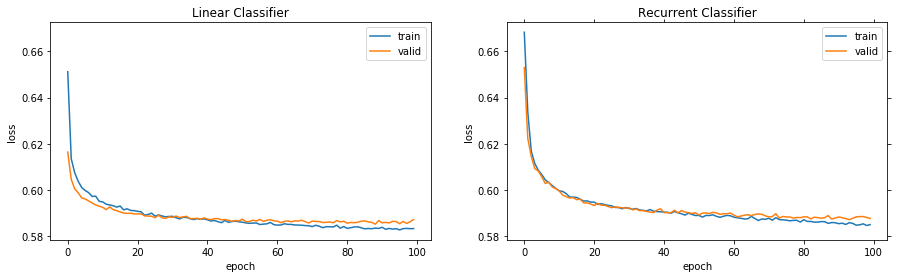

In [14]:
fig, (ax0, ax1) = plt.subplots(
    figsize=(15,4), nrows=1, ncols=2, sharey=True)

ax0.plot(linear_loss[0], label='train')
ax0.plot(linear_loss[1], label='valid')
ax0.set_title('Linear Classifier')
ax0.set_ylabel('loss')
ax0.set_xlabel('epoch')
ax0.legend()

ax1.plot(recurrent_loss[0], label='train')
ax1.plot(recurrent_loss[1], label='valid')
ax1.set_title('Recurrent Classifier')
ax1.set_ylabel('loss')
ax1.set_xlabel('epoch')
ax1.legend()
ax1.tick_params(reset=True)

plt.show()

### Testing the trained models

In [15]:
## Load the saved models

# Linear
linear_classifier.load_state_dict(
    torch.load('linear_classifier.pt'))

# Recurrent
recurrent_classifier.load_state_dict(
    torch.load('recurrent_classifier.pt'))

print('Models loaded successfully')

Models loaded successfully


In [16]:
## Test models

print('Linear Classifier')
loss = validate(linear_classifier, test_dataloader, verbose=True)

print('\nRecurrent Classifier')
loss = validate(recurrent_classifier, test_dataloader, verbose=True)

Linear Classifier
	Validation ... loss:  0.5791
		TP: 3123	FP: 1782	OP: 4905
		FN: 1164	TN: 3465	ON: 4629
		CP: 4287	CN: 5247
	Accuracy: 69.10%	Precision:  0.64	Recall:  0.73

Recurrent Classifier
	Validation ... loss:  0.5783
		TP: 2656	FP: 1375	OP: 4031
		FN: 1631	TN: 3872	ON: 5503
		CP: 4287	CN: 5247
	Accuracy: 68.47%	Precision:  0.66	Recall:  0.62
